## Q Estimate over whole section

In [447]:
# Import Modules
import numpy as np
import scipy
import scipy.signal as sp
import matplotlib.pyplot as plt
import segyio

### Load in data

In [448]:
segy = segyio.open('finalstack.sgy', ignore_geometry= True)

In [449]:
#Define Window length:
wl = 64 # for 100ms at 0.004 sampling = 25
#half window length
hwl = int(round(wl/2))


# Define Bandwidth
lbw = 3
ubw =30 # bandwidth


### Convert Segy data to array

In [450]:
ntrace = len(segy.trace)
ltrace = len(segy._samples)

datawhole = np.empty([ltrace,ntrace])
a = 0
i = 0
for i in segy.trace:
    datawhole[:,a] = np.asarray(i[0:ltrace])
    a=a+1

### Sense Trace parameters

In [451]:
dt = (segy._samples[1] - segy._samples[0])/1000
fs = 1/dt
time = segy._samples/1000

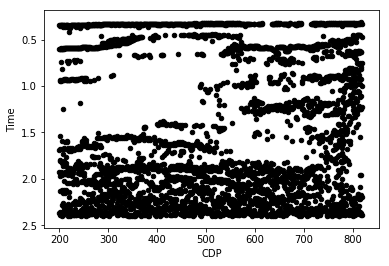

In [455]:
qvec = []
c = []
for j in range(200,ntrace):
    
    data = datawhole[0:600,j] 
    time = time[0:len(data)]
    
    analytical_signal = sp.hilbert(data)
    amplitude_envelope = np.abs(analytical_signal)
    
    
    maxs = np.empty([0,10])
    tot = len(amplitude_envelope)
    maxx = np.argmax(amplitude_envelope)

    # finds max at least every 25 points  ~ 100ms  to get seperate events
    for ty in range(10):
        if len(amplitude_envelope[maxx+30:tot]) == 0:
            pass
        else:
            maxx = np.argmax(amplitude_envelope[maxx+30:tot]) +  maxx + 30
            maxs = np.append(maxs,[maxx])
    
    maxx = np.argmax(amplitude_envelope)
        
    # add first max back 
    maxs = np.insert(maxs,0,maxx)
    
###########################################################################################   
    
    # Create frequency array
    f=np.arange(0,(round(wl/2)))/wl*fs
    
    maxs = np.array(maxs, dtype=np.int64)
    #display(time[maxs])
    windup = maxs +(wl/2)
    winddown = maxs -(wl/2)

    #windup = maxs +wl
    #winddown = maxs 

    #windup = maxs
    #winddown = maxs -wl


 
    results = np.empty((len(maxs), wl))
    po = 0
    for po in range(len(maxs)):
    
        windowss  = data[int(winddown[po]):int(windup[po])]
        padded = np.concatenate((windowss, np.zeros(wl)))  
        
        ampl = np.fft.fft(padded) / wl 
        amplitudea = np.abs(ampl)
        results[po,:] = amplitudea[:wl]
    
    
###############################################################################################
    x = f[lbw:ubw]
    sf = []


    for gh in range(len(maxs)-1):
        spec =  np.log(results[gh+1,0:hwl]/ results[gh,0:hwl])        
        [grr,inn] =  np.polyfit(x,spec[lbw:ubw],1)
        yfit = inn + grr*x
    
        # calculate time difference between windows and save to arry
        t = time[maxs[gh+1]] - time[maxs[gh]]
        
        # Calulate Q and save to array   
        q = -1*np.pi*t/grr
        sf = np.append(sf,[q],axis = 0)
    
#######################################################################################################
    # Plot shows where all the events are 
    # Need to find a way to fill inbetween values with the corresponding q values stored in sf
    
    for jk in range(0,len(time[maxs])):
        plt.figure(1)
        plt.scatter(j,time[maxs[jk]],c= 'k',s=20)
        plt.gca().invert_yaxis()
        plt.xlabel('CDP')
        plt.ylabel('Time')


###################################################################################################
    # Make a an array and fill values with Q?
    a = 0*np.ones(maxs[0])
         # -----------> trace length but 500 as only taking first 500 points
    c = []
    for mk in range(0,len(maxs)):
        if mk+1 >=len(maxs):
            pass
        elif  mk >= len(sf):
            pass
        else:
            b = sf[mk]*np.ones(maxs[mk+1]-maxs[mk])
            c = np.append(c,[b])
    
    qtimes = np.insert(c,0,a)
    padlen = len(data) - len(qtimes)
    padq = np.concatenate((qtimes, np.zeros(padlen))) 
    
    qvec = np.append(qvec,[padq])
    

    



C:\Users\ee18s2p\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\ee18s2p\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


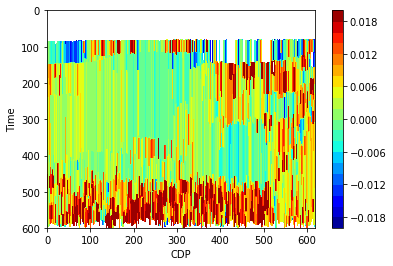

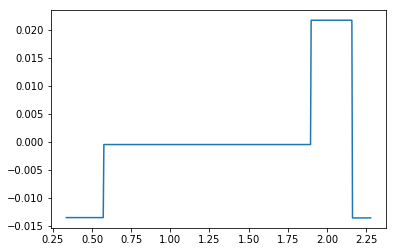

In [456]:
qc = np.reshape(qvec,(int(len(qvec)/len(data)),len(data)))
qc = np.transpose(qc)
#qc = scipy.ndimage.zoom(qc, 3)

#levels = np.linspace(0,500,25)
levels = np.linspace(-0.02,0.02,21)
plt.figure(2)
plt.contourf(1/qc,levels, cmap = 'jet')
#plt.imshow(1/qc,cmap = 'jet',vmin = -0.01, vmax = 0.01)
plt.colorbar()
plt.xlabel('CDP')
plt.ylabel('Time')
plt.gca().invert_yaxis()
    #display(sf)
    #display(np.shape(qtimes))
    #display(qtimes[1,:])    
    #display(maxs[0])
    

plt.figure(3)
plt.plot(time,1/qc[:,88])
